In [18]:
from pathlib import Path
import logging

from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, rdFingerprintGenerator, Draw

from matplotlib import pyplot as plt
from pandas import Series
import seaborn as sns
import colorcet as cc
import pandas as pd
import numpy as np

In [7]:
logger = logging.getLogger(__name__)

formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(logging.INFO)


In [8]:
# project data root directory
base_data_dir = Path().cwd().parents[0] / "assets/dataset/raw"

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")


## Challenge Data: ExpansionRX

In [6]:
df_expansionrx_teaser = pd.read_csv(base_data_dir / "ExpansionRX/expansion_teaser.csv")

logger.info(f"Dataframe shape: {df_expansionrx_teaser.shape}")
logger.info(f"Dataframe columns: {df_expansionrx_teaser.columns.tolist()}")

INFO:__main__:Dataframe shape: (532, 11)
INFO:__main__:Dataframe columns: ['Molecule Name', 'SMILES', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']


In [23]:
def calc_stats(series: Series) -> str:
    """
    Calculate summary statistics for a pandas Series and format as a string.

    Parameters
    ----------
    series : pandas.Series
        Numeric column to summarize.

    Returns
    -------
    str
        Formatted string with min, max, mean, median, std, skew, kurtosis, and count.
    """
    stats = series.agg([
        "min", "max", "median", "mean", "std", "skew", "kurt", "count"
    ])
    stat_text = (
        f"count: {int(stats['count'])}\nmin: {stats['min']:.3g}\nmax: {stats['max']:.3g}\nmean: {stats['mean']:.3g}"
        f"\nmedian: {stats['median']:.3g}\nstd: {stats['std']:.3g}"
        f"\nskew: {stats['skew']:.3g}\nkurtosis: {stats['kurt']:.3g}"
    )
    return stat_text


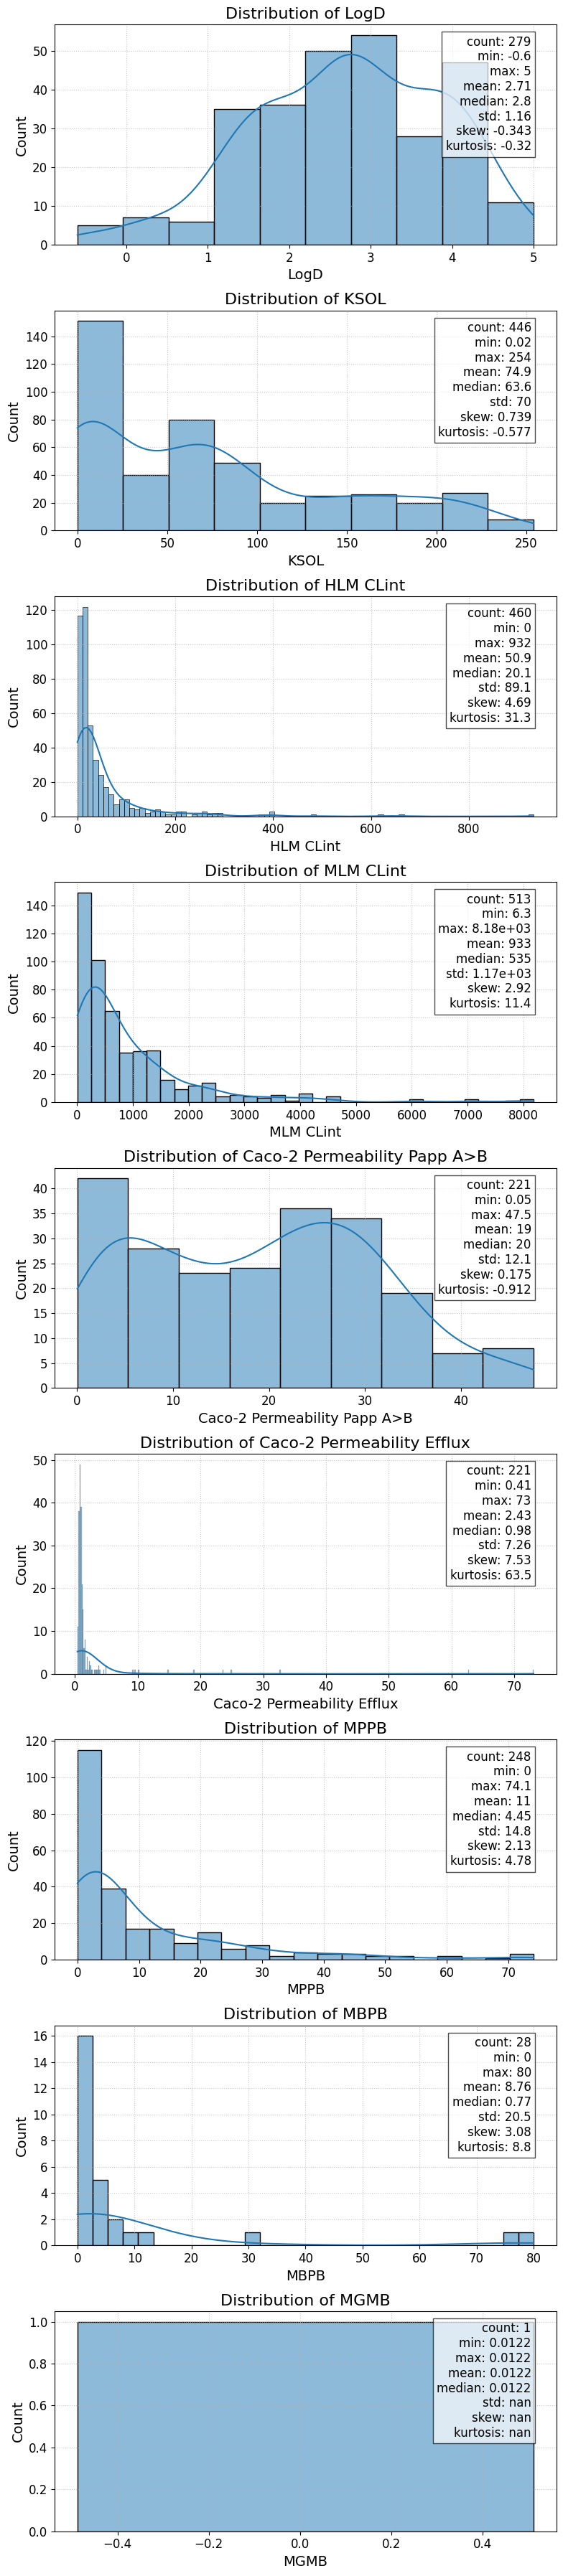

In [27]:
# Plot distributions for each numeric column with summary statistics
numeric_cols = df_expansionrx_teaser.select_dtypes(include=["number"]).columns
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 4 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    ax = axes[i] if len(numeric_cols) > 1 else axes
    sns.histplot(df_expansionrx_teaser[col], kde=True, ax=ax)
    stat_text = calc_stats(df_expansionrx_teaser[col])
    ax.set_title(f"Distribution of {col}", fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.grid(True, linestyle=":", alpha=0.7)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.text(
        0.95,
        0.95,
        stat_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
    )
fig.tight_layout()
plt.show()

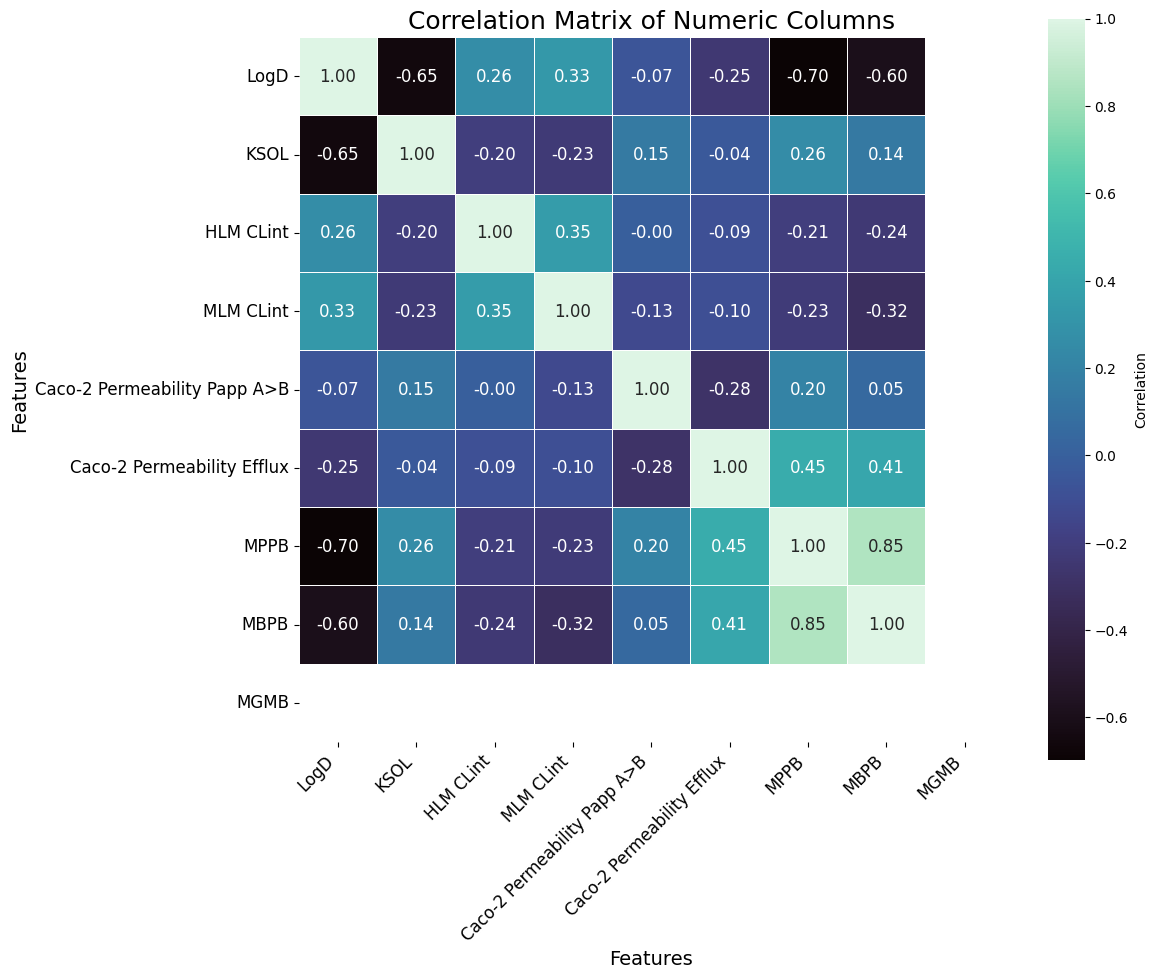

In [28]:
corr = df_expansionrx_teaser[numeric_cols].corr()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    corr,
    annot=True,
    cmap="mako",
    fmt=".2f",
    ax=ax,
    square=True,
    cbar_kws={"label": "Correlation"},
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12},
)
ax.set_title("Correlation Matrix of Numeric Columns", fontsize=18)
ax.set_xlabel("Features", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
fig.tight_layout()

## KERMT Dataset

In [31]:
files_biogen = [
    "KERMT/export_public_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

df_kermt_public = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_public = pd.concat(df_kermt_public, ignore_index=True)
logger.info(f"KERMT Public Dataframe shape: {df_kermt_public.shape}")
logger.info(f"KERMT Public Dataframe columns: {df_kermt_public.columns.tolist()}")

2025-10-21 22:38:51,784 - __main__ - INFO - KERMT Public Dataframe shape: (114112, 26)
INFO:__main__:KERMT Public Dataframe shape: (114112, 26)
2025-10-21 22:38:51,785 - __main__ - INFO - KERMT Public Dataframe columns: ['smiles', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Dog_fraction_unbound_plasma', 'Human_fraction_unbound_plasma', 'Monkey_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'Papp_Caco2', 'Pgp_human', 'hERG_binding', 'LogD_pH_7.4', 'kinetic_logSaq', 'thermo_logSaq', 'VDss_dog', 'VDss_human', 'VDss_monkey', 'VDss_rat']
INFO:__main__:KERMT Public Dataframe columns: ['smiles', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Do

In [36]:
# TODO: look for 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB'
df_kermt_public_admet = df_kermt_public[[
    "LogD_pH_7.4",  # LogD (pH 7.4)
    "kinetic_logSaq",  # KSOL (pH 7.4) in [log(M)]
]]

In [32]:
files_biogen = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

df_kermt_biogen = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_biogen = pd.concat(df_kermt_biogen, ignore_index=True)
logger.info(f"KERMT Biogen Dataframe shape: {df_kermt_biogen.shape}")
logger.info(f"KERMT Biogen Dataframe columns: {df_kermt_biogen.columns.tolist()}")

2025-10-21 22:39:16,515 - __main__ - INFO - KERMT Biogen Dataframe shape: (3521, 7)
INFO:__main__:KERMT Biogen Dataframe shape: (3521, 7)
2025-10-21 22:39:16,516 - __main__ - INFO - KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']
INFO:__main__:KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']
INFO:__main__:KERMT Biogen Dataframe shape: (3521, 7)
2025-10-21 22:39:16,516 - __main__ - INFO - KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']
INFO:__main__:KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']
